In [66]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from plotnine import *

In [67]:
data = pd.read_csv('barkbeetle_dataset.csv')

**TODO**

* Sortieren der Bezirke nach Waldgröße (evt erstmal nur Betrachtung der kritischen districts)
* scatterplot Fichtenwaldgröße über Zugang

In [68]:
data.head()

,REVUFBADR,Jahr,ZR,Eigentumsgruppe,Zugang,Abgang,ETP_mean,FF1_mean,FF2_mean,FFB_mean,...,TN0_mean,TX0_mean,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,county_name,district_name
0,2501,2007,06 Juni,SW,5.0,0.0,110.063631,2.973737,2.187542,2.314478,...,12.705051,24.916160,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
1,2501,2007,08 August,SW,12.0,12.0,96.605054,2.509764,1.842424,2.053872,...,11.786532,24.279797,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
2,2501,2007,10 Oktober-Dezember,SW,2.0,0.0,20.636252,3.778900,2.786419,2.681594,...,1.476655,7.364197,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
3,2501,2008,04 April,SW,1.0,0.0,56.318853,2.989899,2.194276,2.314478,...,3.410774,13.134343,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide
4,2501,2008,06 Juni,SW,2.0,0.0,120.191235,2.705051,2.015488,2.162963,...,10.505051,24.718181,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,Bautzen,Elsterheide


In [60]:
data['area_endangered'] = data.area_nse+data.area_se

In [61]:
x = data.groupby('area_endangered').mean()['Zugang'].index
y = data.groupby('area_endangered').mean()['Zugang'].values

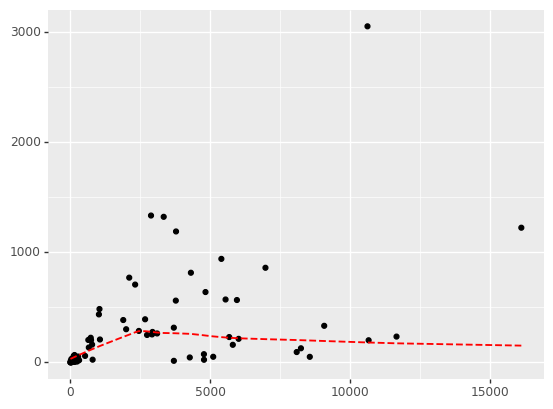

<ggplot: (-9223371892264356796)>

In [62]:
(
    ggplot(aes(x,y)) 
    + geom_point()
)


C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
C:\Users\Yannic\.conda\envs\python377\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 637 rows containing missing values.


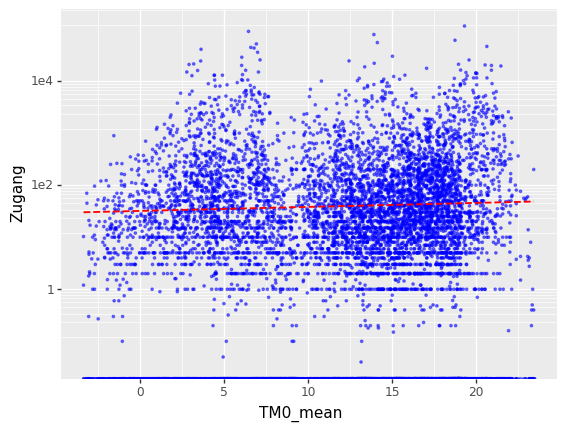

<ggplot: (-9223371892264532536)>

In [65]:

(
    ggplot(data, aes('TM0_mean', 'Zugang')) 
    + geom_point(alpha=0.5, size=0.5, color='blue')
    + geom_smooth(color = 'red', size = .75, linetype = 'dashed', se=False)
    + scale_y_log10()
 #   + theme_classic()
)

#ggsave(plot=p, filename='map.png', dpi=300, width=8, height=5)